In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd

In [0]:
train_ds = pd.read_csv('/content/drive/My Drive/credit/trainDS.csv')
test_ds = pd.read_csv('/content/drive/My Drive/credit/testDS.csv')

Let's start from source data, making a little data preprocessing:

In [0]:
from fastai.tabular import *

As it Neural Net, we can't just put to input categorical features without data preprocessing such as scaling, embedding etc.

So, fastai will do it for us:

In [0]:
dep_var = 'target'
cat_names = ['feature2', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9','feature4']
cont_names = ['age', 'feature1', 'feature3']
procs = [FillMissing, Categorify, Normalize]

In [0]:
train_ds.feature4 = train_ds.feature4.replace(' ', '')
train_ds.feature9 = train_ds.feature9.replace(' ', '')

In [0]:
train_ds = train_ds.sort_values(by='target', ascending=False)
train_ds

,feature1,age,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,target
18952,1.000000,29,1,529.000000,1300,3,1,0,1,0,1
9314,0.124761,29,0,0.841542,1400,6,0,0,0,0,1
9309,0.497543,40,0,0.198534,1500,4,2,0,0,0,1
29876,0.203918,59,4,0.110979,12587,8,0,0,1,0,1
9302,0.839109,45,1,0.611049,3583,16,0,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...
25305,0.232698,37,0,0.088482,3333,5,0,0,0,0,0
25306,0.004256,48,0,0.518332,12300,12,0,3,0,2,0
25307,0.922164,37,0,0.420341,1700,7,0,0,0,0,0
25308,0.064688,60,0,0.202250,10664,22,0,3,0,1,0


In [0]:
data = (TabularList.from_df(train_ds, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(3915,17590)))
                           .label_from_df(cols=dep_var)
                           .add_test(test_ds)
                           .databunch())

Defining model:

In [0]:
f1 = FBeta(beta=1)
recall = Recall()
learn = tabular_learner(data, 
                        layers=[200,100],
                        metrics = [f1, recall])

learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(24, 9)
    (2): Embedding(5, 4)
    (3): Embedding(6, 4)
    (4): Embedding(4, 3)
    (5): Embedding(7, 5)
    (6): Embedding(8867, 260)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=292, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,f_beta,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 2.09E-02


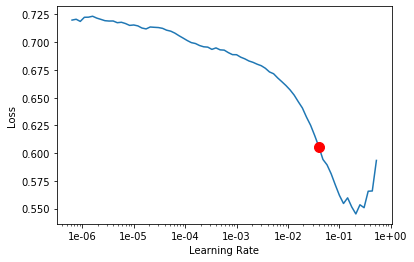

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,f_beta,recall,time
0,0.183795,0.189690,0.354325,0.261491,00:40


It looks better than RF's performance.

We will save this model:

In [0]:
learn.save('first_model')

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

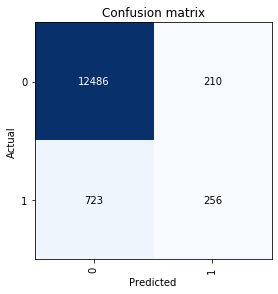

In [0]:
interp.plot_confusion_matrix()

In [0]:
# learn.load('first_model');

It's time to try preprocesed data:

In [0]:
new_train_ds = pd.read_csv('/content/drive/My Drive/credit/new_trainDS.csv')
new_test_ds = pd.read_csv('/content/drive/My Drive/credit/new_testDS.csv')

In [0]:
new_train_ds.head()

,Unnamed: 0,feature1,age,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,target,ranked_feature3,feature4_is_none,feature9_is_none
0,0,0.001963,42,0,0.079941,0.054000,7,0,0,0,0.0,0,0.143922,False,False
1,1,0.004538,86,0,3.000000,0.205608,2,0,0,0,0.0,0,0.768273,True,True
2,2,0.023044,61,0,0.419916,0.200000,18,0,2,0,1.0,0,0.560252,False,False
3,3,0.121242,48,0,0.526589,0.100000,12,0,1,0,1.0,0,0.644618,False,False
4,4,1.000000,49,3,0.256567,0.236000,3,3,1,1,2.0,1,0.358808,False,False


In [0]:
new_cat_names = ['feature2', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature4_is_none', 'feature9_is_none']
new_cont_names = ['age', 'feature1', 'ranked_feature3', 'feature4']

In [0]:
new_train_ds = new_train_ds.sort_values(by='target', ascending=False)
new_train_ds = new_train_ds.drop(columns=['feature3', 'Unnamed: 0'])

In [0]:
new_train_ds

,feature1,age,feature2,feature4,feature5,feature6,feature7,feature8,feature9,target,ranked_feature3,feature4_is_none,feature9_is_none
18952,1.000000,29,1,0.05200,3,1,0,1,0.0,1,0.864396,False,False
9314,0.124761,29,0,0.05600,6,0,0,0,0.0,1,0.747707,False,False
9309,0.497543,40,0,0.06000,4,2,0,0,0.0,1,0.281306,False,False
29876,0.203918,59,4,0.50348,8,0,0,1,0.0,1,0.175719,False,False
9302,0.839109,45,1,0.14332,16,0,0,0,4.0,1,0.687196,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25305,0.232698,37,0,0.13332,5,0,0,0,0.0,0,0.152287,False,False
25306,0.004256,48,0,0.49200,12,0,3,0,2.0,0,0.639609,False,False
25307,0.922164,37,0,0.06800,7,0,0,0,0.0,0,0.560729,False,False
25308,0.064688,60,0,0.42656,22,0,3,0,1.0,0,0.285564,False,False


In [0]:
new_data = (TabularList.from_df(new_train_ds, cat_names=new_cat_names, cont_names=new_cont_names, procs=procs)
                           .split_by_idx(list(range(3915,17590)))
                           .label_from_df(cols=dep_var)
                           .add_test(new_test_ds)
                           .databunch())

We want to save more information, so we will define emb_szs={'feature5' : 24} for 5th feature:

In [0]:
learn1 = tabular_learner(new_data,
                         layers=[10,40,40,10],
                         metrics = [f1, recall],
                         emb_szs={'feature5' : 24}
                         )
learn1.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(24, 24)
    (2): Embedding(5, 4)
    (3): Embedding(6, 4)
    (4): Embedding(4, 3)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=53, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=10, out_features=40, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=40, out_features=10, bias=True)
    (

In [0]:
learn1.lr_find()

epoch,train_loss,valid_loss,f_beta,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E+00
Min loss divided by 10: 1.10E-01


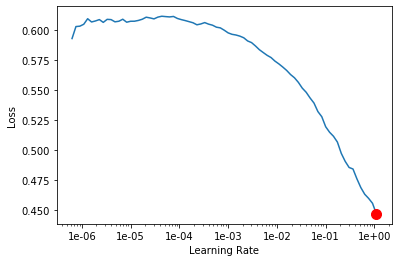

In [0]:
learn1.recorder.plot(skip_end=10,suggestion=True)

In [0]:
learn1.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,f_beta,recall,time
0,0.181874,0.188743,0.351541,0.256384,00:13


Pretty close to first one, let's try do one more epoch with smaller step:

In [0]:
learn1.save('second_model')

In [0]:
learn1.lr_find()

epoch,train_loss,valid_loss,f_beta,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


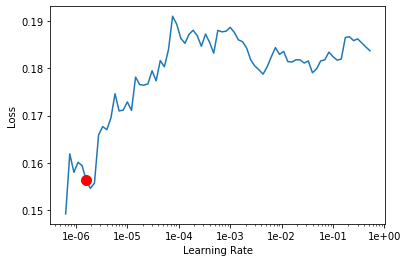

In [0]:
learn1.recorder.plot(skip_end=10,suggestion=True)

In [0]:
learn1.fit_one_cycle(1, 1e-6)

epoch,train_loss,valid_loss,f_beta,recall,time
0,0.186793,0.189103,0.284820,0.185904,00:13


There was no way to raise the metrics, so let's use the first model.

In [0]:
preds1,y1,losses1 = learn1.get_preds(with_loss=True)
interp1 = ClassificationInterpretation(learn1, preds1, y1, losses1)

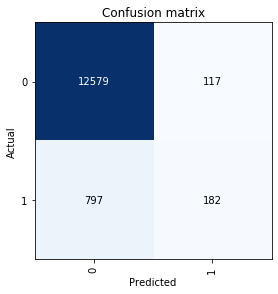

In [0]:
interp1.plot_confusion_matrix()

In [0]:
learn.export()

In [0]:
path=learn.path

In [0]:
tabList = TabularList.from_df(test_ds, cat_names=cat_names, cont_names=cont_names, procs=procs)

learn = load_learner(path, test=tabList)

In [0]:
test_pred, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
pred_for_sub = np.argmax(to_np(test_pred), axis=1)

In [0]:
sub = pd.DataFrame(pred_for_sub, columns=['target'])

We will do submission of this model, but our goal is to use Blending, so then we will save probabilities, that we got from NN:

In [0]:
sub.to_csv('/content/drive/My Drive/credit/submission.csv')

In [0]:
predictions = train_ds.iloc[3915:17590].copy()

In [0]:
predictions

,feature1,age,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,target
59586,0.675929,67,0,0.801082,7575,14,0,2,0,0,1
14782,0.729130,47,4,0.572032,7100,12,0,2,0,2,1
25109,0.578890,49,3,0.449300,3500,7,1,1,1,0,1
25112,1.000000,57,1,0.401299,2000,4,2,1,2,2,1
59539,0.188208,33,0,0.462181,8500,10,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
39428,0.004444,30,0,0.004329,6775,2,0,0,0,3,0
47841,0.117874,54,0,10.145553,3125,10,0,2,0,0,0
47842,0.000000,69,0,0.004329,5683,2,0,0,0,0,0
39427,0.000000,42,0,0.355265,7416,12,0,2,0,2,0


In [0]:
predictions['losses'] = losses
predictions['preds'] = to_np(preds)[:, 0]

In [0]:
predictions

,feature1,age,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,target,losses,preds
59586,0.675929,67,0,0.801082,7575,14,0,2,0,0,1,3.108189,0.955318
14782,0.729130,47,4,0.572032,7100,12,0,2,0,2,1,1.162521,0.687303
25109,0.578890,49,3,0.449300,3500,7,1,1,1,0,1,0.552023,0.424216
25112,1.000000,57,1,0.401299,2000,4,2,1,2,2,1,0.497389,0.391884
59539,0.188208,33,0,0.462181,8500,10,0,2,0,0,1,3.304100,0.963268
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39428,0.004444,30,0,0.004329,6775,2,0,0,0,3,0,0.025243,0.975073
47841,0.117874,54,0,10.145553,3125,10,0,2,0,0,0,0.017805,0.982353
47842,0.000000,69,0,0.004329,5683,2,0,0,0,0,0,0.004855,0.995157
39427,0.000000,42,0,0.355265,7416,12,0,2,0,2,0,0.024982,0.975328


In [0]:
test_predictions = test_ds.copy()


In [0]:
test_predictions['preds'] = to_np(test_pred)[:, 0]

And saving results:

In [0]:
predictions.to_csv('/content/drive/My Drive/credit/train_predictions.csv', index_label='idx')
test_predictions.to_csv('/content/drive/My Drive/credit/test_predictions.csv', index_label='idx')